# Policy exploration #

This notebook contains the exploration of the possible set of policy alternatives. Given the multi-actor decsion-making arena for water management, it is important to consider what possible preferred policy options could entail for other actors. Hence, exploring the policy options space could profide insights into multiple viable - but general - policy options. They are general in the sense that not one specific objective is centered in the search for a policy, and hence it is as objective as possible to find an effective policy. The latter assumes that all actors agree that minimizing deaths and damage costs is important. 

The found policy options originating in the policy space are compared to the base case results. In so doing, we assess whether any policy will improve the current situation and if a 'group' of policies may be found which have a common characteristic that seems to result in particulary preferred outcomes. For instance, policies that use RfR and dike heightening combined may be very effective in reducing the deaths.

Throughout the notebook, guiding insights and next steps in the analysis are discussed.

In [1]:
# import the libaries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np
import pickle

# Import the workbench and model
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities
from dike_model_function import DikeNetwork 
from ema_workbench import load_results
from problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

Given the water management simulation model which includes different policy levers (RfR, dike heightening, and evacuation), we use the ema_workbench to randomly generate 100 policies and evaluate their performance under 400 scenarions. This thus results in 40.000 experiments. 

In [2]:
# run the model with randomly generating policy options
dike_model, planning_steps = get_model_for_problem_formulation(5)

def sum_over(*args):
    return sum(args)

# This part is commented out so we only had to run it once
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=400, policies=100)

# utilities.save_results(results, '../results/400times100PoliciesPF5.csv')

In [3]:
from ema_workbench import load_results
experiments_p, outcomes_p = load_results('../results/40000scenarios.tar.gz')
outcomes_df_p = pd.DataFrame.from_dict(outcomes_p)
outcomes_df_p.head()

[MainProcess/INFO] results loaded succesfully from C:\Users\irene\OneDrive\Documenten\GitHub\EPA1361\final assignment\results\40000scenarios.tar.gz


,A.1_Expected Annual Damage 0,A.1_Dike Investment Costs 0,A.1_Expected Number of Deaths 0,A.2_Expected Annual Damage 0,A.2_Dike Investment Costs 0,A.2_Expected Number of Deaths 0,A.3_Expected Annual Damage 0,A.3_Dike Investment Costs 0,A.3_Expected Number of Deaths 0,A.4_Expected Annual Damage 0,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,0.0,8.526436e+07,0.0,5.302356e+07,0,0.005742,0.0,3.139880e+07,0.0,1.069181e+07,...,2.568188e+07,0.0,0.0,8.673386e+06,0.0,0.000000e+00,3.948301e+07,0.000000,217800000.0,0.000000
1,0.0,8.526436e+07,0.0,1.357645e+06,0,0.000244,0.0,3.139880e+07,0.0,8.357101e+05,...,2.568188e+07,0.0,0.0,8.673386e+06,0.0,8.432576e+05,3.948301e+07,0.000116,217800000.0,73.837395
2,0.0,8.526436e+07,0.0,2.171279e+07,0,0.002411,0.0,3.139880e+07,0.0,0.000000e+00,...,2.568188e+07,0.0,0.0,8.673386e+06,0.0,0.000000e+00,3.948301e+07,0.000000,217800000.0,0.000000
3,0.0,8.526436e+07,0.0,2.157793e+07,0,0.003005,0.0,3.139880e+07,0.0,0.000000e+00,...,2.568188e+07,0.0,0.0,8.673386e+06,0.0,0.000000e+00,3.948301e+07,0.000000,217800000.0,0.000000
4,0.0,8.526436e+07,0.0,6.413019e+07,0,0.008581,0.0,3.139880e+07,0.0,0.000000e+00,...,2.568188e+07,0.0,0.0,8.673386e+06,0.0,2.566302e+07,3.948301e+07,0.002150,217800000.0,1395.133165


In [5]:
# function to aggregate over time and locations
def aggregate_df(df):
    df_aggregate_time = pd.DataFrame()
    df_aggregate_time_location = pd.DataFrame()
    locations = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
    step = ['0', '1', '2']
    metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
    
    for metric in metrics:
        if metric == "RfR Total Costs" or metric == "Expected Evacuation Costs":

            columns = [metric + ' ' + time for time in step]

            df_aggregate_time_location[metric + ' time aggregate'] = df[columns].sum(axis=1)
        else:
            for location in locations:
                columns = [location + '_' + metric + ' ' + time for time in step]

                df_aggregate_time[location + '_' + metric + ' time aggregate'] = df[columns].sum(axis=1)
            
            columns_locations = [location + '_' + metric + ' time aggregate' for location in locations]
            df_aggregate_time_location[metric + ' time location aggregate'] = df_aggregate_time[columns_locations].sum(axis=1)
    
    df_aggregate_time_location['Total Policy Costs'] = df_aggregate_time_location['Dike Investment Costs time location aggregate'] +\
                                                       df_aggregate_time_location['RfR Total Costs time aggregate'] +\
                                                       df_aggregate_time_location['Expected Evacuation Costs time aggregate']
    
    return df_aggregate_time, df_aggregate_time_location

In [6]:
df_t_p, df_tl_p = aggregate_df(outcomes_df_p)
df_tl_p.head()

,Expected Annual Damage time location aggregate,Dike Investment Costs time location aggregate,Expected Number of Deaths time location aggregate,RfR Total Costs time aggregate,Expected Evacuation Costs time aggregate,Total Policy Costs
0,6.640217e+07,5.214857e+08,0.006540,1.032400e+09,4342.720024,1.553890e+09
1,1.431763e+08,5.214857e+08,0.020768,1.032400e+09,14135.706539,1.553900e+09
2,5.264942e+07,5.214857e+08,0.005515,1.032400e+09,3435.481123,1.553889e+09
3,2.574227e+07,5.214857e+08,0.003705,1.032400e+09,2114.795713,1.553888e+09
4,5.248435e+08,5.214857e+08,0.056785,1.032400e+09,41013.023532,1.553927e+09


In [7]:
# determine the range of the outcomes which can be achieved with policies
max_range = df_tl_p.max()
min_range = df_tl_p.min()

with open('../results/min_max_range_randompolicies.pickle', 'wb') as f:
    pickle.dump([max_range, min_range], f)

In [8]:
# load the basecase results
experiments_b, outcomes_b = load_results('../results/basecase_results.tar.gz') 
outcomes_df_b = pd.DataFrame.from_dict(outcomes_b)


df_t_b, df_tl_b = aggregate_df(outcomes_df_b)
df_tl_b.head()

[MainProcess/INFO] results loaded succesfully from C:\Users\irene\OneDrive\Documenten\GitHub\EPA1361\final assignment\results\basecase_results.tar.gz


,Expected Annual Damage time location aggregate,Dike Investment Costs time location aggregate,Expected Number of Deaths time location aggregate,RfR Total Costs time aggregate,Expected Evacuation Costs time aggregate,Total Policy Costs
0,2.834163e+09,0,1.931043,0.0,0.0,0.0
1,5.035985e+09,0,5.212136,0.0,0.0,0.0
2,3.860589e+09,0,4.232087,0.0,0.0,0.0
3,2.891039e+09,0,2.097578,0.0,0.0,0.0
4,1.878022e+09,0,3.630789,0.0,0.0,0.0


In [9]:
# add a column indicating basecase or random and join the outcomes 
# to one file
df_tl_b['Policy'] = 'basecase'
df_tl_p['Policy'] = 'random'
df_agg = df_tl_b.append(df_tl_p)

labels = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs', 'Total Policy Costs', 'Policy']
df_agg.columns = labels

C:\Users\irene\anaconda3\envs\gds\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\irene\anaconda3\envs\gds\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\irene\anaconda3\envs\gds\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\irene\anaconda3\envs\gds\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


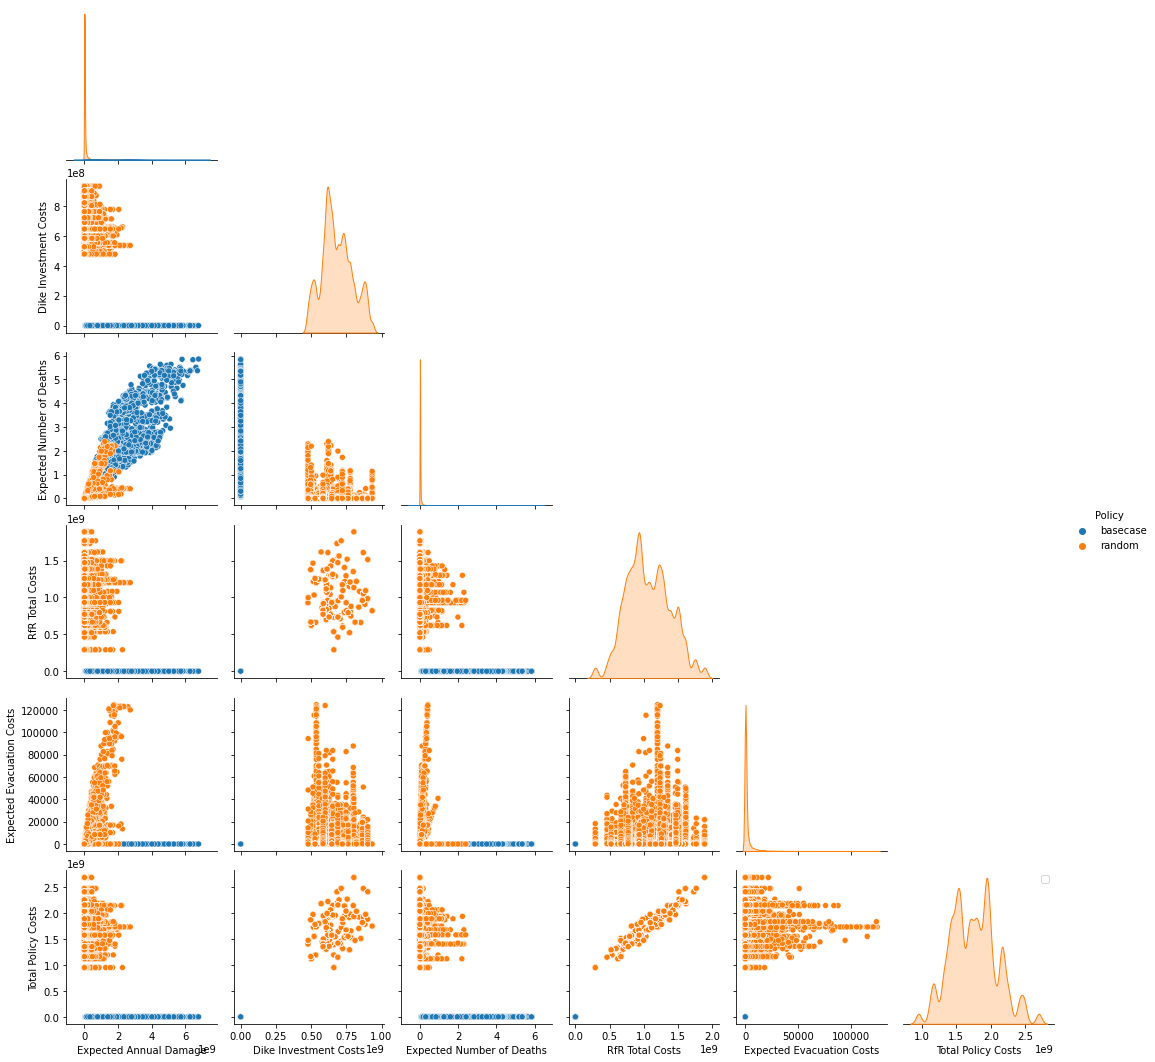

In [10]:
#Now that a combined dataframe has been created, plotting the base case against the random policy runs is now easy.
g = sns.pairplot(df_agg, hue='Policy', hue_order=["basecase", "random"], corner=True)
plt.legend()

plt.show()

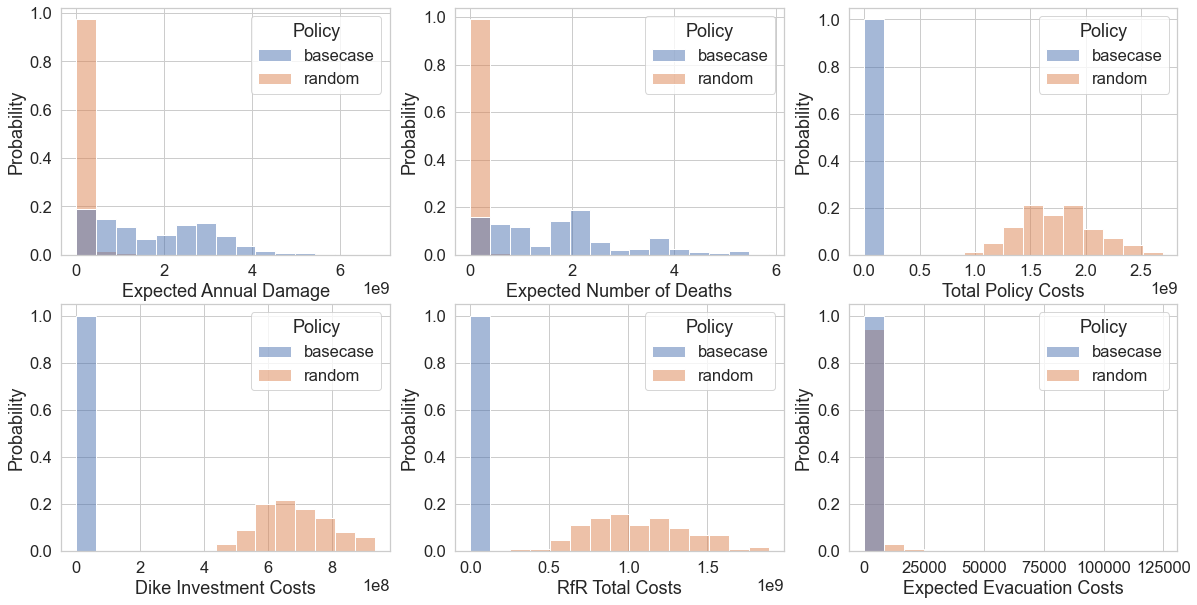

In [17]:
#Create 4 histograms for the 4 KPI's, in which base case is plotted against random policies.
f, axes = plt.subplots(2, 3, figsize=(20,10))
sns.set(style="whitegrid", font_scale=1.5)

sns.histplot(df_agg, x='Expected Annual Damage', hue='Policy',  kde=False, bins=15, stat='probability', common_bins=True, common_norm=False, ax=axes[0,0])

sns.histplot(df_agg, x='Expected Number of Deaths', hue='Policy',  kde=False, bins=15, stat='probability', common_bins=True, common_norm=False, ax=axes[0,1])

sns.histplot(df_agg, x='Total Policy Costs', hue='Policy',  kde=False, bins=15, stat='probability', common_bins=True, common_norm=False, ax=axes[0,2])

sns.histplot(df_agg, x='Dike Investment Costs', hue='Policy',  kde=False, bins=15, stat='probability', common_bins=True, common_norm=False, ax=axes[1,0])

sns.histplot(df_agg, x='RfR Total Costs', hue='Policy',  kde=False, bins=15, stat='probability', common_bins=True, common_norm=False, ax=axes[1,1])

sns.histplot(df_agg, x='Expected Evacuation Costs', hue='Policy',  kde=False, bins=15, stat='probability', common_bins=True, common_norm=False, ax=axes[1,2])

plt.rcParams["axes.labelsize"] = 18
plt.savefig("../images/randompolicies.png", bbox_inches = 'tight', pad_inches = 0)

In [12]:
df_tl_b.describe()

,Expected Annual Damage time location aggregate,Dike Investment Costs time location aggregate,Expected Number of Deaths time location aggregate,RfR Total Costs time aggregate,Expected Evacuation Costs time aggregate,Total Policy Costs
count,5.000000e+03,5000.0,5000.000000,5000.0,5000.0,5000.0
mean,1.807784e+09,0.0,1.724467,0.0,0.0,0.0
std,1.275904e+09,0.0,1.246566,0.0,0.0,0.0
min,3.863705e+07,0.0,0.060585,0.0,0.0,0.0
25%,6.162722e+08,0.0,0.632465,0.0,0.0,0.0
50%,1.710881e+09,0.0,1.861629,0.0,0.0,0.0
75%,2.822598e+09,0.0,2.213149,0.0,0.0,0.0
max,6.790428e+09,0.0,5.855678,0.0,0.0,0.0


In [13]:
df_tl_p.describe()

,Expected Annual Damage time location aggregate,Dike Investment Costs time location aggregate,Expected Number of Deaths time location aggregate,RfR Total Costs time aggregate,Expected Evacuation Costs time aggregate,Total Policy Costs
count,4.000000e+04,4.000000e+04,40000.000000,4.000000e+04,40000.000000,4.000000e+04
mean,5.012333e+07,6.828150e+08,0.021542,1.065600e+09,1809.832293,1.748417e+09
std,1.556100e+08,1.085213e+08,0.103718,3.172310e+08,6495.205007,3.353875e+08
min,0.000000e+00,4.777737e+08,0.000000,2.904000e+08,0.000000,9.519951e+08
25%,0.000000e+00,6.092314e+08,0.000000,8.242250e+08,0.000000,1.510762e+09
50%,5.867396e+06,6.662392e+08,0.001257,1.037100e+09,108.260448,1.733957e+09
75%,2.918380e+07,7.513263e+08,0.008106,1.289075e+09,923.123181,1.955140e+09
max,2.730021e+09,9.334020e+08,2.391760,1.888800e+09,124637.324051,2.692329e+09
